# Train HeterSUMGraphe

In [1]:
import pandas as pd
import argparse
from time import time
import torch
import numpy as np
import random
from sklearn.utils import shuffle
import json
import os
import networkx as nx
import torch_geometric
from statistics import mean
import matplotlib.pyplot as plt

from tqdm import tqdm

from rouge_score import rouge_scorer

from utils.create_graph_dataset import create_graph_dataset
from utils.GloveMgr import GloveMgr
from utils.DataLoader import DataLoader
from utils.accuracy_nb_sent_per_doc import accuracy_nb_sent_per_doc_fn
from utils.split_all_docs import split_all_docs
from utils.threshold_probs import threshold_probs_by_nb, threshold_probs_by_prop
from utils.accuracy_prop_sent_per_doc import accuracy_prop_sent_per_doc_fn

In [2]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

## (Hyper-)parameters

In [3]:
# Parse args if script mode
parser = argparse.ArgumentParser(description='extractive summary')

parser.add_argument('-is_graphic',type=int,default=1,choices=[0,1])
parser.add_argument('-gpu_num',type=int,default=0)
parser.add_argument('-batch_size',type=int,default=4)
parser.add_argument('-epochs',type=int,default=100)
parser.add_argument('-dataset',type=str,default="data/dailymail.json")

args = None

if is_notebook():
    args = parser.parse_args("")
else:
    args = parser.parse_args()

In [4]:
# parameters
is_graphic = args.is_graphic != 0
cuda_num = args.gpu_num
embed_name = "glove.6B.300"

# hyper-parameters
vocab_size = 50000
batch_size = args.batch_size
epochs = args.epochs
learning_rate = 5e-4
early_stopping = 3
word_blacklist_proportion = 0.1
model_name = "07-train_HeterSUMGraph_DailyMail_TG_GATConv"
sub_folder_name = "model_name__{}__time__{}__embed_name__{}__lr__{}__batch_size__{}__vocab_size__{}__cuda_num__{}__early_stopping__{}".format(model_name, time(), embed_name, learning_rate, batch_size, vocab_size, cuda_num, early_stopping)
checkpoints_folder = "./checkpoints/" + sub_folder_name
average_proportion_of_sentences_per_document = 0.1988573738916917# 0.2670278281534701
average_number_of_sentences_per_document = 3

# print
print("parse:")
print("is_graphic:", is_graphic)
print("cuda_num:", cuda_num)
print("epochs", epochs)
print("batch_size", batch_size)

parse:
is_graphic: True
cuda_num: 0
epochs 100
batch_size 4


## PyTorch initialisation

In [5]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [6]:
# Check if a GPU is available
if torch.cuda.is_available():
    # Display the number of available GPUs
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
    # Display the name of each GPU
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available.")

Number of available GPUs: 1
GPU 0: NVIDIA GeForce RTX 3060


In [7]:
if torch.cuda.is_available():  
  dev = "cuda:" + str(cuda_num) 
else:  
  dev = "cpu" 

device = torch.device(dev)
device

device(type='cuda', index=0)

## Functions

In [8]:
def compute_probs(y_pred):
  probs = []
    
  for y in y_pred:
    if y[0]+y[1] == 0:
      probs.append(0.5)
    else:
      probs.append((y[1] / (y[0]+y[1])).item())
    
  probs = np.array(probs)
      
  return probs

def average(l):
  return sum(l) / len(l)

## Load data

In [9]:
df = pd.read_json(args.dataset)
df = shuffle(df, random_state=0)

df_train = df.iloc[0:193983]
df_val = df.iloc[193983:193983+12147]
df_test = df.iloc[193983+12147:]#30]

In [10]:
df_train.head(2)

,text,summaries,labels,own_labels
139927,"by daily mail reporter published : 17:40 est ,...",the retailer 's altair tent does not come with...,"[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
22992,kompany has allayed any lingering injury fears...,kompany was substituted after 55 minutes of be...,"[0, 0, 0, 1, 0, 0, 1, 1]","[1, 1, 1, 0, 1, 1, 1, 0]"


In [11]:
glovemgr = GloveMgr("./data/glove.6B/glove.6B.300d.txt", vocab_size=vocab_size)

In [12]:
tfidfs_sent = pd.read_json("data/daily_sent_tfidf.json")

In [13]:
tfidfs_dataset = json.load(open("./data/daily_dataset_tfidf.json"))
tfidfs_dataset_sorted = sorted(tfidfs_dataset, key=tfidfs_dataset.get)
word_blacklist = set(tfidfs_dataset_sorted[:int(word_blacklist_proportion*len(tfidfs_dataset_sorted))])

In [14]:
train_dataset = create_graph_dataset(df=df_train, tfidfs_sent=tfidfs_sent, glovemgr=glovemgr, word_blacklist = word_blacklist, remove_unkn_words=False, doc_column_name="text", labels_column_name="own_labels", is_sep_n=True, remove_stop_word = False, stemming=False, trunc_sent=-1, padding_sent=-1, trunc_doc=50)
val_dataset = create_graph_dataset(df=df_val, tfidfs_sent=tfidfs_sent, glovemgr=glovemgr, word_blacklist = word_blacklist, remove_unkn_words=False, doc_column_name="text", labels_column_name="own_labels", is_sep_n=True, remove_stop_word = False, stemming=False, trunc_sent=-1, padding_sent=-1, trunc_doc=50)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader =  DataLoader(val_dataset, batch_size=1, shuffle=False)

In [16]:
test_dataset = create_graph_dataset(df=df_test, tfidfs_sent=tfidfs_sent, glovemgr=glovemgr, word_blacklist = word_blacklist, remove_unkn_words=False, doc_column_name="text", labels_column_name="own_labels", is_sep_n=True, remove_stop_word = False, stemming=False, trunc_sent=-1, padding_sent=-1, trunc_doc=50)
test_loader =  DataLoader(test_dataset, batch_size=1, shuffle=False)

## Graph stats

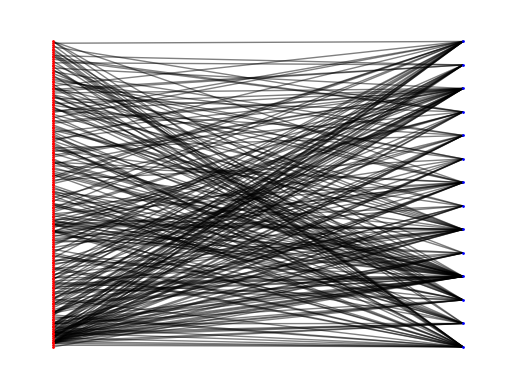

In [17]:
# draw one graph
if is_notebook():
  data = train_dataset.dataset[0]['docs']
  #g = torch_geometric.utils.to_networkx(data)
  #nx.draw(g, node_color= [0 for _ in data.x[0]] + [1 for _ in data.x[1]])
  # Convert to networkx
  G = nx.Graph()
  G.add_nodes_from(range(data.x[0].shape[0]), bipartite=0)
  G.add_nodes_from(range(data.x[1].shape[0]), bipartite=0)
  edge_list = data.edge_index.transpose(0, 1).tolist()
  G.add_edges_from(edge_list)
  # draw
  pos = nx.bipartite_layout(G, nodes=range(data.x[0].shape[0]))
  nx.draw_networkx_nodes(G, pos, nodelist=range(data.x[0].shape[0]), node_color='r', node_size=1)
  nx.draw_networkx_nodes(G, pos, nodelist=range(data.x[0].shape[0], data.x[0].shape[0] + data.x[1].shape[0]), node_color='b', node_size=1)
  nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='k')
  plt.axis('off')
  plt.show()
  

In [18]:
# Average number of distinct word per doc
print("Average number of distinct word per doc:", mean([len(t["docs"].x[0]) for t in train_dataset]))

Average number of distinct word per doc: 282.35966038261085


In [19]:
def sents_len(doc):
  return [torch.sum(torch.sign(s),dim=0).item() for s in doc]

# Average sentence length
lens = []
for t in train_dataset:
  lens = lens + sents_len(t["docs"].x[1])

print("Average sentence len:", mean(lens))

Average sentence len: 26.605073192008078


In [20]:
# Average density
def density(g):
  nb_edges = g.num_edges / 2
  nb_nodes = g.num_nodes
  nb_poss_edges = nb_nodes * (nb_nodes - 1) / 2
  return nb_edges / nb_poss_edges

print("Average density:", mean([density(t["docs"]) for t in train_dataset]))

/home/rsaid/anaconda3/lib/python3.9/site-packages/torch_geometric/data/storage.py:280: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_attr', 'edge_index', 'undirected', 'x'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


Average density: 0.013322891261897363


In [21]:
# Average clustering
def average_clustering(g):
  G = nx.Graph()
  edge_list = g.edge_index.t().tolist()
  G.add_edges_from(edge_list)
  return nx.average_clustering(G)

print("Average clustering:", mean([average_clustering(t["docs"]) for t in train_dataset]))

Average clustering: 0.0


## Model

In [22]:
import torch.nn as nn
from torch_geometric.nn import GATConv

In [23]:
# Position Feed Forward
class PositionwiseFeedForward(nn.Module):
  def __init__(self, d_in, d_out, d_h, dropout=0.1) -> None:
    super(PositionwiseFeedForward, self).__init__()
    self.fc1 = nn.Linear(in_features=d_in, out_features=d_h)
    self.fc2 = nn.Linear(in_features=d_h, out_features=d_out)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = self.dropout(x)
    return self.fc2(x)

In [24]:
class HeterSUMGraph(torch.nn.Module):
  def __init__(self, device, vocab_size, word_embed = None, dim_word_embed = 300, num_iter=3):
    super(HeterSUMGraph, self).__init__()
    self.device = device
    self.num_iter = num_iter

    self.word_emb = nn.Embedding(vocab_size+2, dim_word_embed, padding_idx=0)

    # Load word embedding if specified
    if word_embed is not None:
      self.word_embedding = torch.nn.Embedding.from_pretrained(torch.from_numpy(word_embed).float())

    self.word_emb.weight.requires_grad = False

    # edge_attr embed
    self.edge_attr_embed = nn.Embedding(101, 50)

    # sent CNN
    dim_out_cnn = 64
    self.convs = nn.Sequential(
                            nn.Conv1d(in_channels=300,out_channels=100,kernel_size=3,padding='same'),
                            nn.BatchNorm1d(num_features=100),
                            nn.ReLU(inplace=True),
                            nn.Conv1d(in_channels=100,out_channels=100,kernel_size=4,padding='same'),
                            nn.BatchNorm1d(num_features=100),
                            nn.ReLU(inplace=True),
                            nn.Conv1d(in_channels=100,out_channels=dim_out_cnn,kernel_size=5,padding='same'),
                            nn.BatchNorm1d(num_features=dim_out_cnn),
                            nn.ReLU(inplace=True))

    # sent LSTM
    dim_out_lstm = 32
    self.sent_LSTM = nn.LSTM(input_size=300, hidden_size=dim_out_lstm, batch_first=True, bidirectional=True)

    # sent to word GAT
    # TODO out_channels = 64
    self.s2wGAT = GATConv(in_channels=[128, 300], out_channels=300, heads=8, edge_dim=50, fill_value=0)

    # word to sen GAT
    self.w2sGAT = GATConv(in_channels=[300, 128], out_channels=128, heads=8, edge_dim=50, fill_value=0)

    # ffn sent to word
    self.ffns2w = PositionwiseFeedForward(d_in=8*300, d_out=300, d_h=512)

    # ffn word to sent
    self.ffnw2s = PositionwiseFeedForward(d_in=8*128, d_out=128, d_h=512)

    self.wh = nn.Linear(128, 1)

  def max_pool1d(self, x, seq_lens):
    out = []
    for index,t in enumerate(x):
      if seq_lens[index] == 0:
        t = t[:1]
      else:
        t = t[:seq_lens[index],:]
      t = torch.t(t).unsqueeze(0)
      out.append(torch.avg_pool1d(t, t.size(2)))

    out = torch.cat(out).squeeze(2)
    return out

  def forward(self, data):# In the real implémentation remove nb_sent
    # edge attr embeddings
    edge_attr = torch.floor(data.edge_attr * 100).int()
    edge_attr = self.edge_attr_embed(edge_attr)

    # features
    Xw = data.x[0]
    Xs = data.x[1]
    sent_lens = torch.sum(torch.sign(Xs),dim=1).data
    
    # embeddings
    Xw = self.word_emb(Xw)
    Xs = self.word_emb(Xs)

    # CNN
    XsCNN = self.convs(Xs.permute(0,2,1))
    XsCNN = torch.max_pool1d(XsCNN, XsCNN.size(2)).squeeze(2)

    # LSTM
    # TO DO: ask 
    XsLSTM, _ = self.sent_LSTM(Xs)
    XsLSTM = self.max_pool1d(XsLSTM, sent_lens)
    Xs = torch.cat((XsCNN, XsLSTM), dim=1)

    Hw = Xw
    Hs = Xs

    edge_index_w_i = data.edge_index[1][data.edge_index[1] < len(data.x[0])]
    edge_index_s_j = data.edge_index[0][data.edge_index[1] < len(data.x[0])] - Hw.shape[0]
    edge_attr_w = edge_attr[data.edge_index[1] < len(data.x[0])]
    edge_index_w = torch.stack([edge_index_s_j, edge_index_w_i])

    edge_index_s_i = data.edge_index[1][data.edge_index[1] >= len(data.x[0])] - Hw.shape[0]
    edge_index_w_j = data.edge_index[0][data.edge_index[1] >= len(data.x[0])]
    edge_attr_s = edge_attr[data.edge_index[1] >= len(data.x[0])]
    edge_index_s = torch.stack([edge_index_w_j, edge_index_s_i])

    Hw = torch.layer_norm(Hw, Hw.size()[1:])
    Hs = torch.layer_norm(Hs, Hs.size()[1:])

    for i in range(self.num_iter):
      if i != 0: # H^1w = H^0w = Xw
        Hw = self.s2wGAT(x=[Hs, Hw], edge_index=edge_index_w, edge_attr=edge_attr_w) + torch.cat([Hw] * 8, dim=1)
        Hw = self.ffns2w(Hw)
        Hw = torch.layer_norm(Hw, Hw.size()[1:])

      Hs = self.w2sGAT(x=[Hw, Hs], edge_index=edge_index_s, edge_attr=edge_attr_s) + torch.cat([Hs] * 8, dim=1)
      Hs = self.ffnw2s(Hs)
      Hs = torch.layer_norm(Hs, Hs.size()[1:])

    res = self.wh(Hs)

    res = torch.sigmoid(res).squeeze(-1)

    return res

  def save(self, fname):
    torch.save(self.state_dict(), fname)

  def load(self, fname):
    self.load_state_dict(torch.load(fname))

In [25]:
model = HeterSUMGraph(device=device, vocab_size=vocab_size, word_embed=glovemgr.getEmbeddings(), dim_word_embed=300).to(device=device)

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
criterion = nn.BCELoss()
mae_fn = nn.L1Loss()

## Train

In [28]:
if not os.path.exists(checkpoints_folder):
  os.makedirs(checkpoints_folder)

In [29]:
df_val["doc_splitted"] = split_all_docs(df_val["text"], is_sep_n=True)
val_set = df_val
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

/tmp/ipykernel_180443/3936749812.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["doc_splitted"] = split_all_docs(df_val["text"], is_sep_n=True)


In [30]:
import math

arr_train_loss = []
arr_train_mae = []
arr_train_acc = []
arr_val_loss = []
arr_val_mae = []
arr_val_acc = []

t1 = time()

for epoch in range(1, epochs+1):
  # Train
  model.train()
  nb_batch_train = 0
  total_train_loss = 0
  total_train_mae = 0
  total_train_acc = 0
  with tqdm(train_loader, unit="batch", total=len(train_loader)) as tepoch:
    for batch in tepoch:
      tepoch.set_description(f"Epoch {epoch}")
      #if dev != "cpu":
      #  torch.cuda.empty_cache()
      doc_lens = batch["doc_lens"]
      data = batch["docs"].to(device)
      targets = torch.tensor(batch["labels"], dtype=torch.float).to(device)
      y_pred = model(data)

      loss = criterion(y_pred, targets)
      optimizer.zero_grad()
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), 2.0)
      optimizer.step()
      nb_batch_train += 1
      total_train_loss += loss.item()

      probs = y_pred.tolist() # compute_probs(y_pred)
      probs_tensor = y_pred #torch.tensor(probs, dtype=torch.float).to(device)

      total_train_mae += mae_fn(probs_tensor, targets).item()
      total_train_acc += accuracy_nb_sent_per_doc_fn(probs=probs, targets=targets.cpu().detach().numpy(), doc_lens=doc_lens, average_number_of_sentences_per_document=average_number_of_sentences_per_document)

      tepoch.set_postfix(loss=total_train_loss/nb_batch_train, mae=total_train_mae/nb_batch_train, accuracy=total_train_acc/nb_batch_train)

  # Save model
  model.save(checkpoints_folder + "/" + model_name + "-" + str(epoch) + ".pt")

  # Eval
  model.eval()
  nb_batch_val = 0
  total_val_loss = 0
  total_val_mae = 0
  total_val_acc = 0
  total_r1 = 0
  total_r2 = 0
  total_rl = 0

  del loss
  del y_pred

  if dev != "cpu":
    torch.cuda.empty_cache()

  for i, batch in enumerate(val_loader):
    #if dev != "cpu":
    #  torch.cuda.empty_cache()
    doc_lens = batch["doc_lens"]
    data = batch["docs"].to(device)
    targets = torch.tensor(batch["labels"], dtype=torch.float).to(device)
    y_pred = model(data)

    loss = criterion(y_pred, targets)
    nb_batch_val += 1
    total_val_loss += loss.item()

    doc = val_set["doc_splitted"].iloc[i]
    summaries = val_set["summaries"].iloc[i]

    indices = torch.argsort(y_pred, descending=True)

    y_pred_thresh = []

    txt = ""

    for j in range(min(len(doc), y_pred.shape[0])):
      txt = txt + ". " + doc[indices[j]]
      y_pred_thresh.append(indices[j])
      if len(txt) >= len(summaries):
        break

    y_pred_thresh.sort()

    txt = ""

    for j in y_pred_thresh:
      txt = txt + ". " + doc[j]

    n = min(len(txt), len(summaries))

    while n < len(txt) and txt[n].isalnum():
      n += 1

    txt = txt[:n]

    #assert len(txt) - len(summaries) <= 20

    scores = scorer.score(summaries, txt)
    total_r1 += scores["rouge1"].recall
    total_r2 += scores["rouge2"].recall
    total_rl += scores["rougeL"].recall

    probs = y_pred.tolist() # compute_probs(y_pred)
    probs_tensor = y_pred #torch.tensor(probs, dtype=torch.float).to(device)

    total_val_mae += mae_fn(probs_tensor, targets).item()
    total_val_acc += accuracy_nb_sent_per_doc_fn(probs=probs, targets=targets.cpu().detach().numpy(), doc_lens=doc_lens, average_number_of_sentences_per_document=average_number_of_sentences_per_document)

  if len(arr_val_loss) >= early_stopping+1:
    if min(arr_val_loss[-early_stopping:]) >= arr_val_loss[-(early_stopping+1)]:
      print("Epoch {} : val loss = {:.3f}, val mae = {:.3f}, val accuracy = {:.3f}, r1 = {:.3f}, r2 = {:.3f}, rL = {:.3f}".format(epoch, total_val_loss / nb_batch_val, total_val_mae / nb_batch_val, total_val_acc / nb_batch_val, total_r1 / nb_batch_val, total_r2 / nb_batch_val, total_rl / nb_batch_val))
      break

  print("Epoch {} : val loss = {:.3f}, val mae = {:.3f}, val accuracy = {:.3f}, r1 = {:.3f}, r2 = {:.3f}, rL = {:.3f}".format(epoch, total_val_loss / nb_batch_val, total_val_mae / nb_batch_val, total_val_acc / nb_batch_val, total_r1 / nb_batch_val, total_r2 / nb_batch_val, total_rl / nb_batch_val))

  del loss
  del y_pred

  if dev != "cpu":
    torch.cuda.empty_cache()

  arr_train_loss.append(total_train_loss / nb_batch_train)
  arr_train_mae.append(total_train_mae / nb_batch_train)
  arr_train_acc.append(total_train_acc / nb_batch_train)

  arr_val_loss.append(total_val_loss / nb_batch_val)
  arr_val_mae.append(total_val_mae / nb_batch_val)
  arr_val_acc.append(total_val_acc / nb_batch_val)

t2 = time()
print("Training duration =", t2-t1)

  0%|          | 0/48496 [00:00<?, ?batch/s]

Epoch 1:   0%|          | 0/48496 [00:00<?, ?batch/s]/home/rsaid/anaconda3/lib/python3.9/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,
Epoch 1: 100%|██████████| 48496/48496 [2:05:19<00:00,  6.45batch/s, accuracy=0.756, loss=0.528, mae=0.347]  


Epoch 1 : val loss = 0.433, val mae = 0.276, val accuracy = 0.831, r1 = 0.348, r2 = 0.135, rL = 0.217


Epoch 2: 100%|██████████| 48496/48496 [2:06:30<00:00,  6.39batch/s, accuracy=0.785, loss=0.442, mae=0.28]   


Epoch 2 : val loss = 0.407, val mae = 0.248, val accuracy = 0.835, r1 = 0.350, r2 = 0.136, rL = 0.217


Epoch 3: 100%|██████████| 48496/48496 [2:07:27<00:00,  6.34batch/s, accuracy=0.786, loss=0.42, mae=0.263]   


Epoch 3 : val loss = 0.398, val mae = 0.254, val accuracy = 0.835, r1 = 0.350, r2 = 0.136, rL = 0.218


Epoch 4: 100%|██████████| 48496/48496 [2:07:13<00:00,  6.35batch/s, accuracy=0.786, loss=0.411, mae=0.256]  


Epoch 4 : val loss = 0.393, val mae = 0.255, val accuracy = 0.836, r1 = 0.351, r2 = 0.137, rL = 0.218


Epoch 5: 100%|██████████| 48496/48496 [2:03:37<00:00,  6.54batch/s, accuracy=0.786, loss=0.406, mae=0.253]  


Epoch 5 : val loss = 0.393, val mae = 0.255, val accuracy = 0.836, r1 = 0.351, r2 = 0.137, rL = 0.218


Epoch 6: 100%|██████████| 48496/48496 [2:03:36<00:00,  6.54batch/s, accuracy=0.786, loss=0.401, mae=0.249]  


Epoch 6 : val loss = 0.390, val mae = 0.249, val accuracy = 0.836, r1 = 0.351, r2 = 0.137, rL = 0.218


Epoch 7: 100%|██████████| 48496/48496 [2:07:16<00:00,  6.35batch/s, accuracy=0.786, loss=0.398, mae=0.247]  


Epoch 7 : val loss = 0.388, val mae = 0.246, val accuracy = 0.837, r1 = 0.351, r2 = 0.137, rL = 0.218


Epoch 8: 100%|██████████| 48496/48496 [2:10:02<00:00,  6.22batch/s, accuracy=0.786, loss=0.395, mae=0.245]  


Epoch 8 : val loss = 0.391, val mae = 0.249, val accuracy = 0.833, r1 = 0.351, r2 = 0.137, rL = 0.218


Epoch 9: 100%|██████████| 48496/48496 [2:11:09<00:00,  6.16batch/s, accuracy=0.787, loss=0.392, mae=0.243]  


Epoch 9 : val loss = 0.390, val mae = 0.237, val accuracy = 0.835, r1 = 0.351, r2 = 0.137, rL = 0.218


Epoch 10: 100%|██████████| 48496/48496 [2:11:33<00:00,  6.14batch/s, accuracy=0.786, loss=0.39, mae=0.242]   


Epoch 10 : val loss = 0.389, val mae = 0.251, val accuracy = 0.836, r1 = 0.351, r2 = 0.137, rL = 0.218


Epoch 11: 100%|██████████| 48496/48496 [2:10:10<00:00,  6.21batch/s, accuracy=0.787, loss=0.389, mae=0.241]  


Epoch 11 : val loss = 0.383, val mae = 0.238, val accuracy = 0.837, r1 = 0.351, r2 = 0.137, rL = 0.218
Training duration = 87354.10136151314


In [31]:
training_metrics = {}
training_metrics["duration"]   = t2 - t1
training_metrics["train_loss"] = arr_train_loss
training_metrics["train_mae"]  = arr_train_mae
training_metrics["train_acc"]  = arr_train_acc
training_metrics["val_loss"]   = arr_val_loss
training_metrics["val_mae"]    = arr_val_mae
training_metrics["val_acc"]    = arr_val_acc

# Save to file in JSON format

with open(checkpoints_folder + "/training_metrics.json", 'w') as fp:
  json.dump(training_metrics, fp)

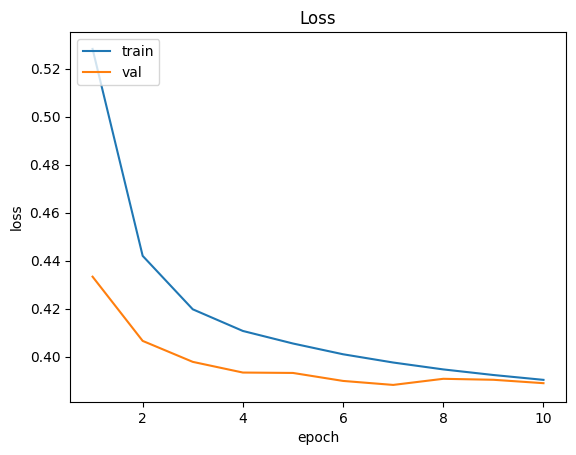

In [32]:
# draw Losses
if is_graphic:
  plt.plot(list(range(1, len(arr_train_loss) + 1)), arr_train_loss, label="train")
  plt.plot(list(range(1, len(arr_val_loss) + 1)), arr_val_loss, label="val")

  plt.title("Loss")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend(loc="upper left")

  plt.show()

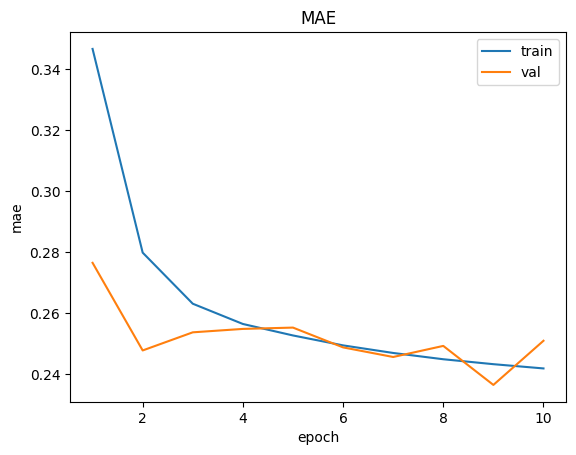

In [33]:
# draw mae
if is_graphic:
  plt.plot(list(range(1, len(arr_train_mae) + 1)), arr_train_mae, label="train")
  plt.plot(list(range(1, len(arr_val_mae) + 1)), arr_val_mae, label="val")

  plt.title("MAE")
  plt.xlabel("epoch")
  plt.ylabel("mae")
  plt.legend(loc="upper right")

  plt.show()

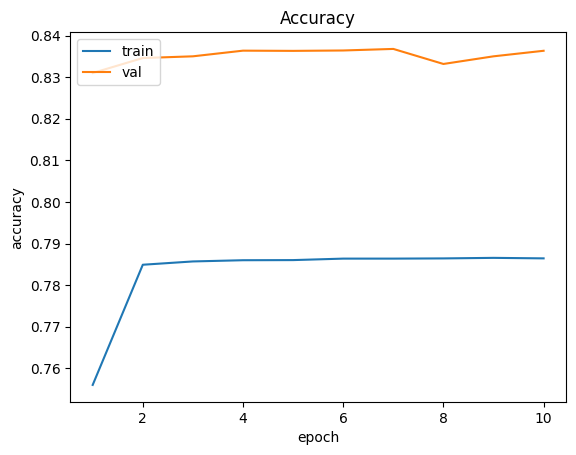

In [34]:
# draw Accuracies
if is_graphic:
  plt.plot(list(range(1, len(arr_train_acc) + 1)), arr_train_acc, label="train")
  plt.plot(list(range(1, len(arr_val_acc) + 1)), arr_val_acc, label="val")

  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.legend(loc="upper left")

  plt.show()

## Eval model

In [35]:
model = HeterSUMGraph(device=device, vocab_size=vocab_size, word_embed=glovemgr.getEmbeddings())

In [36]:
best_epoch = np.argmin(np.array(arr_val_loss)) + 1
model.load(checkpoints_folder + "/" + model_name + "-" + str(best_epoch) + ".pt")
model.to(device)
model.eval()
best_epoch

7

In [37]:
df_test["doc_splitted"] = split_all_docs(df_test["text"], is_sep_n=True)
test_set = df_test

/tmp/ipykernel_180443/3073821175.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["doc_splitted"] = split_all_docs(df_test["text"], is_sep_n=True)


In [38]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
criterion = nn.BCELoss()
mae_fn = nn.L1Loss()

In [39]:
arr_rouge1 = []
arr_rouge2 = []
arr_rougeL = []
arr_loss = []
mae = []
accuracy = []

idx = 0

counter = 0
with tqdm(test_loader, unit="batch", total=len(test_loader)) as tepoch:
  for batch in tepoch:
    tepoch.set_description("Eval model")
    data = batch["docs"].to(device)
    targets = torch.tensor(batch["labels"], dtype=torch.float).to(device)
    y_pred = model(data)

    loss = criterion(y_pred, targets)

    arr_loss.append(loss.item())

    doc = test_set["doc_splitted"].iloc[idx]
    summaries = test_set["summaries"].iloc[idx]

    probs = np.array(y_pred.tolist()) # compute_probs(y_pred)
    probs_tensor = y_pred #torch.tensor(probs, dtype=torch.float).to(device)

    #probs = threshold_probs_by_nb(probs=probs, doc_lens=[probs.shape[0]], average_number_of_sentences_per_document=average_number_of_sentences_per_document)
    #probs = threshold_probs_by_prop(probs=probs, doc_lens=[probs.shape[0]], average_proportion_of_sentences_per_document=average_proportion_of_sentences_per_document)
    indices = torch.argsort(y_pred, descending=True)

    y_pred_thresh = []

    txt = ""

    for i in range(min(len(doc), y_pred.shape[0])):
      txt = txt + ". " + doc[indices[i]]
      y_pred_thresh.append(indices[i])
      if len(txt) >= len(summaries):
        break

    y_pred_thresh.sort()

    txt = ""

    for i in y_pred_thresh:#range(min(len(doc), y_pred.shape[0])):
      txt = txt + ". " + doc[i]

    n = min(len(txt), len(summaries))

    while n < len(txt) and txt[n].isalnum():
      n += 1

    txt = txt[:n]

    #assert len(txt) - len(summaries) <= 20

    scores = scorer.score(summaries, txt)
    arr_rouge1.append(scores["rouge1"].recall)
    arr_rouge2.append(scores["rouge2"].recall)
    arr_rougeL.append(scores["rougeL"].recall)

    mae.append(mae_fn(probs_tensor, targets).item())

    accuracy.append(accuracy_nb_sent_per_doc_fn(probs=probs, targets=targets.cpu().detach().numpy(), doc_lens=[len(probs)], average_number_of_sentences_per_document=average_number_of_sentences_per_document))
    #accuracy.append(accuracy_prop_sent_per_doc_fn(probs=probs, targets=targets.cpu().detach().numpy(), doc_lens=[len(probs)], average_proportion_of_sentences_per_document=average_proportion_of_sentences_per_document))

    tepoch.set_postfix(loss=average(arr_loss), rouge1 = average(arr_rouge1), rouge2 = average(arr_rouge2), rougeL = average(arr_rougeL), accuracy=average(accuracy))
    idx += 1


Eval model:   0%|          | 0/10350 [00:00<?, ?batch/s, accuracy=0.966, loss=0.256, rouge1=0.633, rouge2=0.5, rougeL=0.612]

Eval model: 100%|██████████| 10350/10350 [04:21<00:00, 39.57batch/s, accuracy=0.838, loss=0.387, rouge1=0.35, rouge2=0.136, rougeL=0.218]


In [40]:
test_metrics = {}
test_metrics["accuracy"] = average(accuracy)
test_metrics["mae"]      = average(mae)
test_metrics["rouge1"]   = average(arr_rouge1)
test_metrics["rouge2"]   = average(arr_rouge2)
test_metrics["rougeL"]   = average(arr_rougeL)

# Save to file in JSON format

with open(checkpoints_folder + "/test_metrics.json", 'w') as fp:
  json.dump(test_metrics, fp)

### Lead-3

In [41]:
arr_rouge1 = []
arr_rouge2 = []
arr_rougeL = []
mae = []
accuracy = []

idx = 0
with tqdm(test_loader, unit="batch", total=len(test_loader)) as tepoch:
    for batch in tepoch:
        tepoch.set_description("Lead-3")
        doc = test_set["doc_splitted"].iloc[idx]

        txt = ""

        for i in range(min(len(doc), 3)):
            txt = txt + doc[i]

        summaries = test_set["summaries"].iloc[idx]

        n = min(len(txt), len(summaries))

        while n < len(txt) and txt[n].isalnum():
            n += 1

        txt = txt[:n]

        scores = scorer.score(summaries, txt)
        arr_rouge1.append(scores["rouge1"].recall)
        arr_rouge2.append(scores["rouge2"].recall)
        arr_rougeL.append(scores["rougeL"].recall)

        idx += 1

        tepoch.set_postfix(rouge1 = average(arr_rouge1), rouge2 = average(arr_rouge2), rougeL = average(arr_rougeL))

Lead-3:   0%|          | 0/10350 [00:00<?, ?batch/s, rouge1=0.346, rouge2=0.162, rougeL=0.245]

Lead-3: 100%|██████████| 10350/10350 [01:48<00:00, 95.22batch/s, rouge1=0.331, rouge2=0.125, rougeL=0.207] 


### First n char

In [42]:
arr_rouge1 = []
arr_rouge2 = []
arr_rougeL = []
mae = []
accuracy = []

idx = 0
with tqdm(test_loader, unit="batch", total=len(test_loader)) as tepoch:
    for batch in tepoch:
        tepoch.set_description("First-n-char'")
        doc = test_set["doc_splitted"].iloc[idx]

        txt = ""

        for i in range(len(doc)):
            txt = txt + doc[i]

        summaries = test_set["summaries"].iloc[idx]

        n = min(len(txt), len(summaries))

        while n < len(txt) and txt[n].isalnum():
            n += 1

        txt = txt[:n]

        scores = scorer.score(summaries, txt)
        arr_rouge1.append(scores["rouge1"].recall)
        arr_rouge2.append(scores["rouge2"].recall)
        arr_rougeL.append(scores["rougeL"].recall)

        idx += 1

        tepoch.set_postfix(rouge1 = average(arr_rouge1), rouge2 = average(arr_rouge2), rougeL = average(arr_rougeL))

First-n-char': 100%|██████████| 10350/10350 [01:50<00:00, 93.91batch/s, rouge1=0.337, rouge2=0.128, rougeL=0.21]  


In [43]:
# Does not execute this cell if you want to execute the following cells.
import sys
sys.exit()

SystemExit: 

/home/rsaid/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Others

In [ ]:
import numpy as np
import json

In [ ]:
# Mesurer la moyenne des resultats
dnames = ["model_name__RNN_RNN__time__1677674712.6719887__embed_name__glove.6B.100__lr__0.001__batch_size__32__vocab_size__150000__cuda_num__0",\
          "model_name__RNN_RNN__time__1677674976.7989237__embed_name__glove.6B.100__lr__0.001__batch_size__32__vocab_size__150000__cuda_num__1",\
          "model_name__RNN_RNN__time__1677675018.309817__embed_name__glove.6B.100__lr__0.001__batch_size__32__vocab_size__150000__cuda_num__2",\
          "model_name__RNN_RNN__time__1677675034.4065497__embed_name__glove.6B.100__lr__0.001__batch_size__32__vocab_size__150000__cuda_num__3",\
          "model_name__RNN_RNN__time__1677675050.3008132__embed_name__glove.6B.100__lr__0.001__batch_size__32__vocab_size__150000__cuda_num__4",\
          "model_name__RNN_RNN__time__1677675073.7586496__embed_name__glove.6B.100__lr__0.001__batch_size__32__vocab_size__150000__cuda_num__5"]

In [ ]:
# Temps d'exécution moyen
training_metrics = [json.load(open("./checkpoints/" + dname + "/training_metrics.json")) for dname in dnames]

durations = np.array([tm["duration"] for tm in training_metrics])

print("mean duration = {}+/-{}".format(np.mean(durations), np.std(durations)))

In [ ]:
# Scores
test_metrics = [json.load(open("./checkpoints/" + dname + "/test_metrics.json")) for dname in dnames]

accuracies = np.array([test_metrics[i]["accuracy"] for i in range(len(test_metrics))])
rouge1 = np.array([test_metrics[i]["rouge1"] for i in range(len(test_metrics))])
rouge2 = np.array([test_metrics[i]["rouge2"] for i in range(len(test_metrics))])
rougeL = np.array([test_metrics[i]["rougeL"] for i in range(len(test_metrics))])

print("accuracy = {}+/-{}".format(np.mean(accuracies), np.std(accuracies)))
print("rouge1 = {}+/-{}".format(np.mean(rouge1), np.std(rouge1)))
print("rouge2 = {}+/-{}".format(np.mean(rouge2), np.std(rouge2)))
print("rougeL = {}+/-{}".format(np.mean(rougeL), np.std(rougeL)))